In [1]:
import matplotlib.pyplot as plt

from tqdm import tqdm

import mrob
import sklearn
import sklearn.datasets
import numpy as np
np.set_printoptions(linewidth=160)

import scipy
import scipy.stats
from tqdm import tqdm
from multiprocessing import Pool

import sys
sys.path.insert(0,'.')

from uncertainty import compound_mc

In [2]:
class TestSE3covMonteCarloCompare:
    def __init__(self):
        pass
        
    def generate_random_inputs(self):
        # initialize random initial/incremental pose and their covariances
        # initial pose and covariance
        self.xi_1 = np.random.randn(6)*1e-1
        self.pose_1 = mrob.geometry.SE3(self.xi_1)
        self.covariance_1 = sklearn.datasets.make_spd_matrix(6)

        #incremental pose and covariance
        self.xi_2 = np.random.randn(6)*1e-2
        self.pose_2 = mrob.geometry.SE3(self.xi_2)
        self.covariance_2 = sklearn.datasets.make_spd_matrix(6)*1e-1

    def test_compound_second_order(self, N=3000):
        # generate random input and store it inside self
        self.generate_random_inputs()
        
        # do the truncated monte carlo sampling of N samples and calculate the resulting variance
        mc_covariance = self.get_truncated_mc(self.pose_1,N,2)
        
        # this code is how 2nd order compounding should be called from SE3Cov class        
        cov = mrob.geometry.SE3Cov(self.pose_1, self.covariance_1)
        cov.compound_2nd_order(self.pose_2, self.covariance_2)
        
        # do the 2nd order compounding:
        # calculate adjoint for T_1 pose
        adj = mrob.geometry.SE3Cov.notation_transform(self.pose_1.adj())
        
        
        # first I transform sigmas to the Barfoot notation i.e. to (position, rotation) order
        # covariances 
        sigma_2 = mrob.geometry.SE3Cov.notation_transform(self.covariance_1) + \
                            adj@mrob.geometry.SE3Cov.notation_transform(self.covariance_2)@adj.transpose() 
        
        # transform back to MROB notation
        sigma_2 = mrob.geometry.SE3Cov.notation_transform(sigma_2)
        
        error_se3cov = np.linalg.norm(cov.cov() - mc_covariance)

        # error is the Frobenius norm of the difference between covarioance obtained from 
        # truncated monte carlo and compounding formulas 
        error_python = np.linalg.norm(sigma_2 - mc_covariance)
        
        return error_python, error_se3cov

    def test_compound_fourth_order(self,N=3000):
        self.generate_random_inputs()
        
        mc_covariance = self.get_truncated_mc(self.pose_1,N,4)
        
        cov = mrob.geometry.SE3Cov(self.pose_1, self.covariance_1)
        cov.compound_4th_order(self.pose_2, self.covariance_2)
        
        error = np.linalg.norm((cov.cov() + cov.cov().transpose())/2 - mc_covariance)
        return error

    def get_truncated_mc(self, T, N, order):
        #by given covariances I generate two normal distributions with zero bias
        norm_var_1 = scipy.stats.multivariate_normal([0,0,0,0,0,0],self.covariance_1,allow_singular=True)
        norm_var_2 = scipy.stats.multivariate_normal([0,0,0,0,0,0],self.covariance_2,allow_singular=True)

        # generate N samples for xi_1 and xi_2
        # Note: these variables are at the MROB notation yet
        xi_1 = norm_var_1.rvs(N)
        xi_2 = norm_var_2.rvs(N)

        # switch to Barfoot notation
        permutation = [3,4,5,0,1,2]
        idx = np.empty_like(permutation)
        idx[permutation] = range(len(permutation))

        xi_1 = xi_1[:,idx]
        xi_2 = xi_2[:,idx]

        # calculating the adjoint matrix from pose_1
        adj = mrob.geometry.SE3Cov.notation_transform(T.adj())
        
        # multiplying xi_2 points by adjoint from the left
        xi_2 = [adj@xi for xi in xi_2]

        # calculating the covariance by definition - summing up all pairs of outer products of random values
        covariance = np.zeros((6,6))
        for i in (range(N)):
            covariance = covariance \
                        + xi_1[i].reshape(6,1)@xi_1[i].reshape(6,1).transpose() \
                        + xi_2[i].reshape(6,1)@xi_2[i].reshape(6,1).transpose()

            # additional terms for 4th order
            if order == 4:
                # curley_wedge operator here is assumed in mrob notation
                # so I permute the xi arguments to have curley_wedge result in barfoot notation
                
                xi_1_w = (mrob.geometry.curley_wedge(xi_1[i][[3,4,5,0,1,2]]))
                xi_2_w = (mrob.geometry.curley_wedge(xi_2[i][[3,4,5,0,1,2]]))
                
                covariance = covariance \
                    + 1./12.*((xi_1_w@xi_1_w)@(xi_2[i].reshape(6,1)@xi_2[i].reshape(6,1).transpose()) \
                    + (xi_2[i].reshape(6,1)@xi_2[i].reshape(6,1).transpose())@(xi_1_w@xi_1_w).transpose() \
                    + (xi_2_w@xi_2_w)@(xi_1[i].reshape(6,1)@xi_1[i].reshape(6,1).transpose()) \
                    + (xi_1[i].reshape(6,1)@xi_1[i].reshape(6,1).transpose())@(xi_2_w@xi_2_w).transpose())\
                    + 1./4.*xi_1_w@(xi_2[i].reshape(6,1)@xi_2[i].reshape(6,1).transpose())@xi_1_w.transpose()
        
        # nomalizing the covariance by the number of samples
        covariance = covariance / N

        # switching back to the MROB notation
        covariance = mrob.geometry.SE3Cov.notation_transform(covariance)
        return covariance

    def new_mc(self,T,N,order):
        T, Sigma = compound_mc(self.pose_1, self.covariance_1, self.pose_2, self.covariance_2, N)
        
        return Sigma

    def test_second_order_with_new_mc(self, N=3000):
        # generate random input and store it inside self
        self.generate_random_inputs()
        
        # do the truncated monte carlo sampling of N samples and calculate the resulting variance
#         mc_covariance = self.get_truncated_mc(self.pose_1,N,2)
        mc_covariance = self.new_mc(self.pose_1,N,2)
        
        # this code is how 2nd order compounding should be called from SE3Cov class        
        cov = mrob.geometry.SE3Cov(self.pose_1, self.covariance_1)
        cov.compound_2nd_order(self.pose_2, self.covariance_2)
        
        # do the 2nd order compounding:
        # calculate adjoint for T_1 pose
        adj = self.pose_1.adj()
        
        
        # first I transform sigmas to the Barfoot notation i.e. to (position, rotation) order
        # covariances 
        sigma_2 = self.covariance_1 + adj@self.covariance_2@adj.transpose() 
        
        error_se3cov = np.linalg.norm(cov.cov() - mc_covariance)

        # error is the Frobenius norm of the difference between covarioance obtained from 
        # truncated monte carlo and compounding formulas 
        error_python = np.linalg.norm(sigma_2 - mc_covariance)
        
        return error_python, error_se3cov

In [3]:
test = TestSE3covMonteCarloCompare()

In [4]:
# N = np.linspace(10,300_000,num=5)
N = np.logspace(1,4,num=7)
# N = np.logspace(1,4,num=5)
M = 10

In [5]:
errors_2_se3cov = np.zeros((M,len(N)))
errors_2_python = np.zeros((M,len(N)))

for n in tqdm(range(len(N))):
    for m in range(M):
        errors_2_python[m,n], errors_2_se3cov[m,n] = test.test_compound_second_order(int(N[n]))

100%|██████████| 7/7 [00:01<00:00,  3.86it/s]


In [6]:
new_errors_2_se3cov = np.zeros((M,len(N)))
new_errors_2_python = np.zeros((M,len(N)))

for n in tqdm(range(len(N))):
    for m in range(M):
        new_errors_2_python[m,n], new_errors_2_se3cov[m,n] = test.test_second_order_with_new_mc(int(N[n]))

100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


In [7]:
errors_4_se3cov = np.zeros((M,len(N)))

for n in tqdm(range(len(N))):
    for m in range(M):
        errors_4_se3cov[m,n] = test.test_compound_fourth_order(int(N[n]))

100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


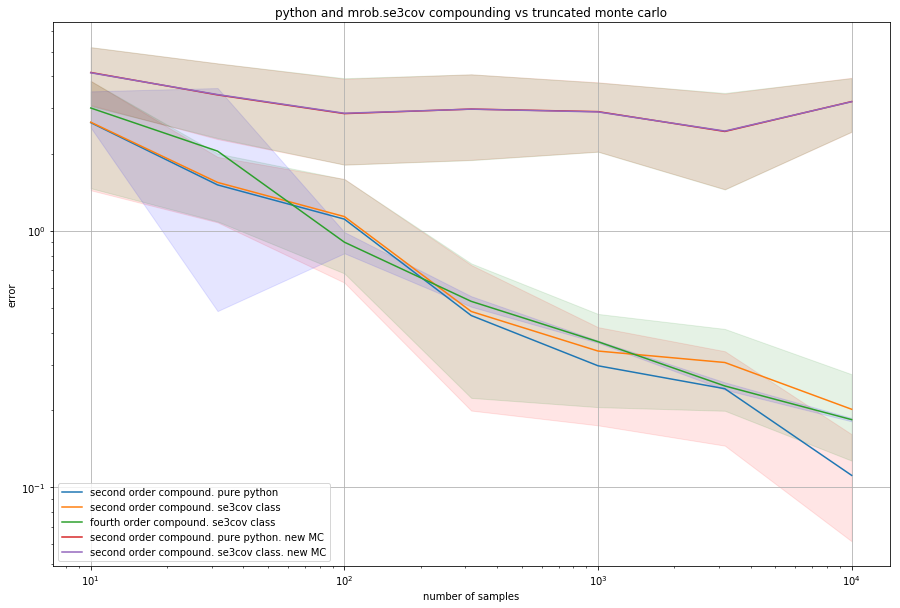

In [10]:
plt.figure(figsize=(15,10))

mean = np.mean(errors_2_python, axis=0)
std = np.std(errors_2_python,axis=0)
plt.loglog(N, mean, label='second order compound. pure python')
plt.fill_between(N, (mean-std), (mean+std), color='r', alpha=.1)


mean = np.mean(errors_2_se3cov, axis=0)
std = np.std(errors_2_se3cov,axis=0)
plt.loglog(N, mean, label='second order compound. se3cov class')
plt.fill_between(N, (mean-std), (mean+std), color='g', alpha=.1)


mean = np.mean(errors_4_se3cov, axis=0)
std = np.var(errors_4_se3cov,axis=0)
plt.loglog(N, mean, label='fourth order compound. se3cov class')
plt.fill_between(N, (mean-std), (mean+std), color='b', alpha=.1)

mean = np.mean(new_errors_2_python, axis=0)
std = np.std(new_errors_2_python,axis=0)
plt.loglog(N, mean, label='second order compound. pure python. new MC')
plt.fill_between(N, (mean-std), (mean+std), color='r', alpha=.1)

mean = np.mean(new_errors_2_se3cov, axis=0)
std = np.std(new_errors_2_se3cov,axis=0)
plt.loglog(N, mean, label='second order compound. se3cov class. new MC')
plt.fill_between(N, (mean-std), (mean+std), color='g', alpha=.1)

plt.title('python and mrob.se3cov compounding vs truncated monte carlo')
plt.xlabel('number of samples')
plt.ylabel('error')
plt.legend()
plt.grid()

In [9]:
print('2nd order, se3cov class:\n',np.mean(errors_2_se3cov,axis=0)) # mrob::SE3cov.second_order
print('2nd order, python:\n',np.mean(errors_2_python,axis=0)) # pure python
print('2nd order, se3cov class, new MC:\n',np.mean(new_errors_2_se3cov,axis=0)) # mrob::SE3cov.second_order
print('2nd order, python, new MC:\n',np.mean(new_errors_2_python,axis=0)) # pure python
print('4th order, se3cov class:\n',np.mean(errors_4_se3cov,axis=0)) # mrob::Se3cov.fourth_order

2nd order, se3cov class:
 [2.65112674 1.5434238  1.13534293 0.48398776 0.33914304 0.30598775 0.20098977]
2nd order, python:
 [2.6405593  1.50931213 1.10955153 0.46672764 0.29710354 0.24175925 0.11097772]
2nd order, se3cov class, new MC:
 [4.133399   3.39856086 2.87270941 2.980714   2.90792712 2.44800323 3.18750106]
2nd order, python, new MC:
 [4.14396172 3.38784925 2.86368791 2.98275992 2.91553921 2.4393054  3.19135778]
4th order, se3cov class:
 [3.01188256 2.04452445 0.90211842 0.53011002 0.36887434 0.24782434 0.18311523]


# 6D distribution covariance estimation

In [68]:
n_samples = 1_000_0
covariance_1 = sklearn.datasets.make_spd_matrix(6)
norm_var_1 = scipy.stats.multivariate_normal([0,0,0,0,0,0],covariance_1,allow_singular=True)

xi_1 = norm_var_1.rvs(n_samples)
xi_1.shape

(10000, 6)

In [69]:
covariance = np.zeros((6,6))
for i in tqdm(range(n_samples)):
    covariance += xi_1[i].reshape(6,1)@xi_1[i].reshape(6,1).transpose()
covariance = covariance / n_samples
np.linalg.norm(covariance - covariance_1)

100%|██████████| 10000/10000 [00:00<00:00, 147838.24it/s]


0.03390977875142922

In [70]:
xi = np.array([0.1, 0.2, 0.3,4,5,6])

In [71]:
T = mrob.geometry.SE3(xi)

In [72]:
T.T()

array([[ 0.9357548 , -0.28316496,  0.21019171,  3.81202092],
       [ 0.30293271,  0.95058062, -0.06803132,  5.28658606],
       [-0.18054008,  0.12733457,  0.97529031,  5.87160232],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

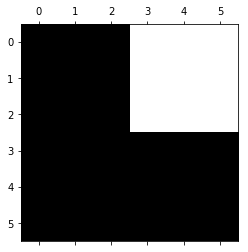

In [73]:
plt.spy(T.adj())

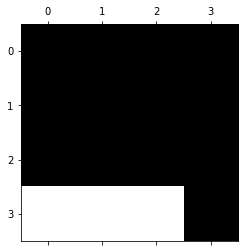

In [74]:
plt.spy(T.T())

In [75]:
mrob.geometry.hat6(xi)

array([[ 0. , -0.3,  0.2,  4. ],
       [ 0.3,  0. , -0.1,  5. ],
       [-0.2,  0.1,  0. ,  6. ],
       [ 0. ,  0. ,  0. ,  0. ]])

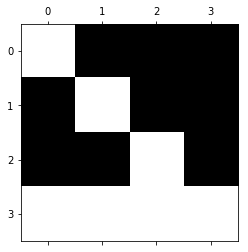

In [76]:
plt.spy(mrob.geometry.hat6(xi))

In [77]:
new_T = mrob.geometry.SE3()
new_T.update_lhs(xi)

In [32]:
new_T.T() == T.T()

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])